In [83]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

# We are going to invert the training and labels (char -> image)
gen_train_dataset, gen_train_labels = train_labels, train_dataset
gen_valid_dataset, gen_valid_labels = valid_labels, valid_dataset
gen_test_dataset, gen_test_labels = test_labels, test_dataset

batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, num_labels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))

  tf_valid_dataset = tf.constant(gen_valid_dataset)
  tf_test_dataset = tf.constant(gen_test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([num_labels, image_size * image_size * 4]))
  biases = tf.Variable(tf.zeros([image_size * image_size * 4]))
  weights_2 = tf.Variable(
    tf.truncated_normal([image_size * image_size * 4, image_size * image_size]))
  biases_2 = tf.Variable(tf.zeros([image_size * image_size]))
  
  # Training computation.
  logits = tf.matmul(tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases), weights_2) + biases_2
  loss = tf.reduce_sum(tf.pow(logits-tf_train_labels, 2))/(2*batch_size)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = logits
  valid_prediction = tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases), weights_2) + biases_2
  test_prediction = tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), weights_2) + biases_2

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [210]:

batch_size = 50000

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, num_labels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))

  tf_valid_dataset = tf.constant(gen_valid_dataset)
  tf_test_dataset = tf.constant(gen_test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([num_labels, image_size * image_size * 4]))
  biases = tf.Variable(tf.zeros([image_size * image_size * 4]))
  weights_2 = tf.Variable(
    tf.truncated_normal([image_size * image_size * 4, image_size * image_size]))
  biases_2 = tf.Variable(tf.zeros([image_size * image_size]))
  
  # Training computation.
  def single_layer(data):
    reshape = tf.reshape(tf.matmul(data, weights) + biases, [-1, image_size*2, image_size*2, 1])
    return tf.nn.max_pool(reshape, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  def two_layer(data):
    return tf.matmul(tf.matmul(data, weights) + biases, weights_2) + biases_2
  logits = tf.reshape(single_layer(tf_train_dataset), [-1, image_size*image_size])
  loss = tf.reduce_sum(tf.pow(logits-tf_train_labels, 2))/(2*batch_size)
  
  # Optimizer.
  optimizer = tf.train.AdamOptimizer(1.0).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = logits
  valid_prediction = tf.reshape(single_layer(tf_valid_dataset), [-1, image_size*image_size])
  test_prediction = tf.reshape(single_layer(tf_test_dataset), [-1, image_size*image_size])

In [213]:
def accuracy(predictions, labels):
  return (np.sum(np.power(predictions-labels,2)))/(2*predictions.shape[0])

num_steps = 10

layer_1 = []
layer_2 = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (gen_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = gen_train_dataset[offset:(offset + batch_size), :]
    batch_labels = gen_train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %f" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %f" % accuracy(
        valid_prediction.eval(), gen_valid_labels))
  test_preds = test_prediction.eval()
  print("Test accuracy: %f" % accuracy(test_preds, gen_test_labels))

Initialized
Minibatch loss at step 0: 592.759216
Minibatch accuracy: 593.587840
Validation accuracy: 268.887625
Test accuracy: 103.878894


[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


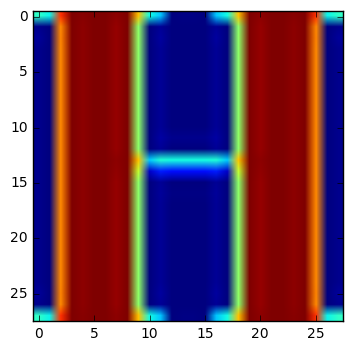

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 5
print(gen_test_dataset[i])
plt.imshow(gen_test_labels.reshape((-1, 28, 28))[i])

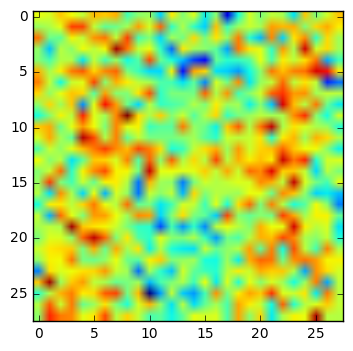

In [217]:
plt.close()
plt.imshow(test_preds.reshape((-1, 28, 28))[i])

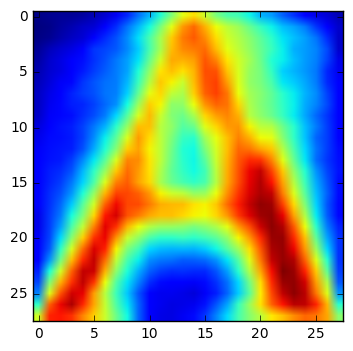

In [209]:
plt.close()
input = np.matrix([0.0,0.0,.0,.0,.0,.0,.0,.0,1.0,0.0])
input2 = np.matrix([1.0,0.0,.0,.0,.0,.0,.0,.0,.0,.0])

plt.imshow((((input2*ow_1)+b_1)).reshape((-1, 28, 28)))

In [127]:
with tf.Session(graph=graph) as session:
  pred_data = single_layer

array([[ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [215]:
import gym

ImportError: No module named 'gym'

In [216]:
version

NameError: name 'version' is not defined